# Exploratory Data Analysis

## Initial Settings

### Roots and Paths

In [1]:
import sys
from pathlib import Path

# Ruta a la raíz del proyecto
project_root = Path().resolve().parent
sys.path.append(str(project_root))

### Libraries and Dependencies

In [2]:
import src.utils as ut
import src.config as cf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_columns = None
sns.set_style('dark')
sns.set_palette('dark')

project path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn
raw data path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn\data\raw_data.csv
clean data path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn\data\clean_data.csv
model path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn\models\model.pkl
results path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn\results


### Data Loading

In [3]:
df = ut.load_data(cf.raw_data_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Preliminary EDA

### Basic Information

In [4]:
# dataset size
print(f'Dimensions: {df.shape}')

# summary table
ut.summary_info(df)

Dimensions: (7043, 21)


Column,Non-Null Count,Missing %,Unique Values,Data Type
customerID,"7,043",0.000000,"7,043",object
DeviceProtection,"7,043",0.000000,3,object
TotalCharges,"7,043",0.000000,"6,531",object
MonthlyCharges,"7,043",0.000000,"1,585",float64
PaymentMethod,"7,043",0.000000,4,object
PaperlessBilling,"7,043",0.000000,2,object
Contract,"7,043",0.000000,3,object
StreamingMovies,"7,043",0.000000,3,object
StreamingTV,"7,043",0.000000,3,object
TechSupport,"7,043",0.000000,3,object


### Missing Values

In [5]:
ut.missing_values_by_pivot(df, 'StreamingTV', return_type='percentage', percentage_base= 'total')

StreamingTV,No,No internet service,Yes
customerID,0.0,0.0,0.0
gender,0.0,0.0,0.0
SeniorCitizen,0.0,0.0,0.0
Partner,0.0,0.0,0.0
Dependents,0.0,0.0,0.0
tenure,0.0,0.0,0.0
PhoneService,0.0,0.0,0.0
MultipleLines,0.0,0.0,0.0
InternetService,0.0,0.0,0.0
OnlineSecurity,0.0,0.0,0.0


## Feature - Target Relevance Analysis

### Numerical Features Relevance

#### Feature - Target Correlations

In [6]:
# peak at unique target values
print(df['Churn'].unique())

['No' 'Yes']


In [7]:
# encoding of target
df['target_encoded'] = df['Churn'].map({'Yes': 1, 'No': 0})

# target - numeric correlations
correlations = df.select_dtypes(include = ['float64', 'int64']).corrwith(df['target_encoded'])
correlations = correlations.sort_values(ascending = False)

# show
print('Target Correlations:')
correlations_table = pd.DataFrame(correlations, columns = ['Correlation'])
correlations_table

Target Correlations:


,Correlation
target_encoded,1.000000
MonthlyCharges,0.193356
SeniorCitizen,0.150889
tenure,-0.352229


#### Feature - Target Correlation Visualization

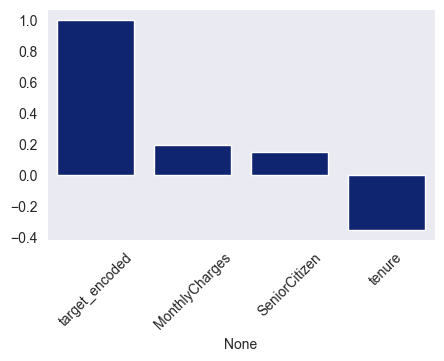

In [8]:
plt.figure(figsize = (5, 3))
sns.barplot(x = correlations.index, y = correlations.values)
plt.xticks(rotation = 45)
plt.show()

#### ANOVA Revelance Analysis

Numerical Features with p-value below 0.05 are more significant. This is modeled through a F-Statistic that measures the difference between groups in the target variable, relative to the inner dispersion

In [9]:
numerical_cols = df.select_dtypes(include = ['int64', 'float64']).drop(columns = ['target_encoded'], errors = 'ignore').columns

anova_results = []

for col in numerical_cols:
    # create groups based on target categories
    groups = [df[df['target_encoded'] == category][col] for category in df['target_encoded'].unique()]
    
    # calculate F-statistic and p-value
    f_stat, p_value = f_oneway(*groups)
    
    # save results in a dictionary
    anova_results.append({'Feature': col, 'F-Statistic': f_stat, 'P-Value': p_value})

# convert results to DataFrame
anova_table = pd.DataFrame(anova_results)

# formatting
anova_table = anova_table.sort_values(by = 'P-Value', ascending = False)

anova_table.style.format({
    'F-Statistic': '{:.2f}',
    'P-Value': '{:.3f}'
})

anova_table
    

,Feature,F-Statistic,P-Value
0,SeniorCitizen,164.041424,3.839860e-37
2,MonthlyCharges,273.463704,2.706646e-60
1,tenure,997.268010,7.999058e-205


### Categorical Features Relevance

#### Categorical Features Selection

In [10]:
cat_columns = list(set(df.columns) - set(numerical_cols))
cat_columns.remove('TotalCharges')
cat_columns.remove('Churn')
cat_columns.remove('target_encoded')

#### Chi - Squared Test

In [11]:
chi2_results = []

for col in cat_columns:
    # contigency table
    contingency_table = pd.crosstab(df[col], df['Churn'])
    
    # chi-squared
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    
    # append results
    chi2_results.append({'Feature': col, 'Chi2': chi2, 'P-Value': p})
    
# formatting
chi2_df = pd.DataFrame(chi2_results).sort_values(by = 'Chi2', ascending = False)

chi2_df.style.format({
    'Chi2': '{:.2f}',
    'P-Value': '{:.3f}'
})

chi2_df

,Feature,Chi2,P-Value
11,customerID,7043.000000,4.943977e-01
6,Contract,1184.596572,5.863038e-258
1,OnlineSecurity,849.998968,2.661150e-185
8,TechSupport,828.197068,1.443084e-180
14,InternetService,732.309590,9.571788e-160
15,PaymentMethod,648.142327,3.682355e-140
3,OnlineBackup,601.812790,2.079759e-131
9,DeviceProtection,558.419369,5.505219e-122
0,StreamingMovies,375.661479,2.667757e-82
7,StreamingTV,374.203943,5.528994e-82


### Feature Ranking

##### Preliminary Preprocessing

In [14]:
df_encoded = df.copy()

for col in cat_columns:
    encoder = LabelEncoder()
    df_encoded[col] = encoder.fit_transform(df_encoded[col])
    
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace = True)

df_encoded.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,target_encoded
0,5375,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,No,0
1,3962,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,No,0
2,2564,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,Yes,1
3,5535,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,No,0
4,6511,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,Yes,1


##### Target - Feature Split

In [15]:
X = df_encoded.drop(['Churn', 'target_encoded'], axis = 1)
y = df_encoded['target_encoded']

In [16]:
X.dtypes

customerID            int32
gender                int32
SeniorCitizen         int64
Partner               int32
Dependents            int32
tenure                int64
PhoneService          int32
MultipleLines         int32
InternetService       int32
OnlineSecurity        int32
OnlineBackup          int32
DeviceProtection      int32
TechSupport           int32
StreamingTV           int32
StreamingMovies       int32
Contract              int32
PaperlessBilling      int32
PaymentMethod         int32
MonthlyCharges      float64
TotalCharges        float64
dtype: object

##### Simple Random Forest Fit

In [18]:
model = RandomForestClassifier(random_state = 123, n_estimators = 100)
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending = False)

##### Ranking Table

In [19]:
importance_df = pd.DataFrame({
    'Feature': feature_importance.index,
    'Importance': feature_importance.values
}).sort_values(by = 'Importance', ascending = False)

importance_df

,Feature,Importance
0,TotalCharges,0.154249
1,MonthlyCharges,0.146836
2,tenure,0.134429
3,customerID,0.130083
4,Contract,0.084434
5,OnlineSecurity,0.043658
6,PaymentMethod,0.042187
7,TechSupport,0.041038
8,OnlineBackup,0.026785
9,InternetService,0.025153


##### Ranking Visualization

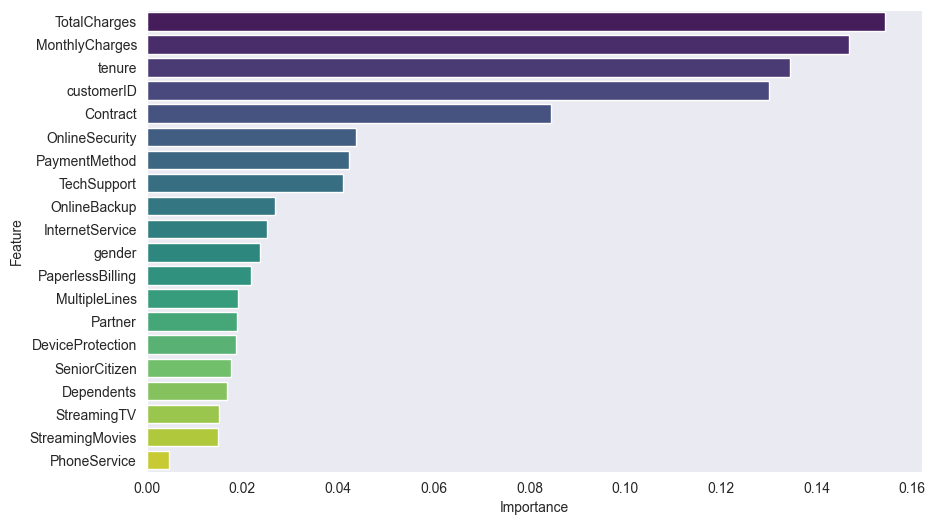

In [21]:
plt.figure(figsize = (10, 6))

sns.barplot(
    x = 'Importance', 
    y = 'Feature', 
    data = importance_df, 
    palette = 'viridis',
    hue = 'Feature',
    dodge = False)
plt.show()

## Numerical Feature Analysis

### Statistical Summary

In [ ]:
# statistical summary
df.describe().applymap(lambda x: ut.format_cell(x)).style.applymap(ut.center_align)

### Histograms

In [ ]:
# create histogram and density curves

for col in numerical_cols:
    sns.histplot(df[col], kde = True, bins = 35)
    plt.title(f'{col} distribution')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

### Box Plots

In [ ]:
for col in numerical_cols:
    sns.boxplot(y = df[col])
    plt.title(f'{col} distribution')
    plt.ylabel({col})
    plt.show()

### Pair Plots

In [ ]:
sns.pairplot(df[numerical_cols])
plt.show()

### Heatmap

In [ ]:
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = 'Blues', cbar = True)
plt.title('Correlation Matrix')
plt.show()

## Categorical Feature Analysis

### Uniqueness

In [ ]:
ut.uniqueness_categorical_columns(df, max_categories = 10)

### Count Plot

In [ ]:
for col in cat_columns:
    sns.countplot(x = col, data = df)
    plt.title(f'{col} distribution')
    plt.show()

### Crosstabs

In [ ]:
#cross_tabs_cols = cat_columns.remove('Churn')
for col in cat_columns:
    cross = pd.crosstab(df[col], df['Churn'])

    sns.heatmap(cross, annot = True, fmt = 'd', cmap = 'Blues', cbar= False)
    plt.show()

In [ ]:
contract_churn = pd.crosstab([df['Contract'], df["PaymentMethod"]], df['Churn'])

sns.heatmap(contract_churn, annot = True, fmt = 'd', cmap = 'Blues')

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

# Mosaic plot entre Contract y Churn
mosaic(df, ['Contract', 'Churn'], title="Contract vs Churn distribution")
plt.show()

## Cross-Variable Feature Analysis

### Swarm Plots

In [ ]:
sns.stripplot(x = 'Contract', y ='MonthlyCharges', data = df, size = 3)
plt.show()

### Catplots

In [ ]:
sns.catplot(x = 'Contract', y = 'MonthlyCharges', hue = 'Churn', col = 'InternetService', kind = 'box', data = df)
plt.subplots_adjust(top = 0.9)
plt.show()

### Scatter Plot

In [ ]:
sns.scatterplot(x = 'tenure', y = 'MonthlyCharges', hue = 'Contract', style = 'Churn', data = df)
plt.show()

### Categorical Line Plots

In [ ]:
sns.lineplot(x = 'tenure', y ='MonthlyCharges', hue = 'Contract', data = df, errorbar = None)
plt.show()

### Stacked Histograms

In [ ]:
for contract in df['Contract'].unique():
    subset = df[df['Contract'] == contract]
    sns.histplot(subset['MonthlyCharges'], label = contract, kde = True, alpha = 0.5)
plt.legend()
plt.show()

### Interactions Heatmap

In [ ]:
pivot_table = pd.pivot_table(
    df,
    values = 'MonthlyCharges',
    index = 'InternetService',
    columns = 'Contract',
    aggfunc = 'mean'   
)

plt.figure(figsize = (5, 3))
sns.heatmap(pivot_table, annot = True, fmt = '.2f', linewidths = 0.5)
plt.title('Average Monthly Charge by Contract Type and Internet Service')
plt.xlabel('Contract')
plt.ylabel('Internet Service')
plt.show()